In [2]:
import deconV as dv
import scout

import glob, tqdm, time, os
import torch
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams


import pandas as pd
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns
import tqdm
import scout

import plotly.graph_objects as go
import plotly.express as px

%load_ext autoreload
%autoreload 2

Global seed set to 0


In [3]:
params = {
    "cell_type_key": "cellType",
    "fig_fmt": "png",

    "selected_ct": ["0", "1", "2"],
    "bulk_file": "../../data/GSE136148/bulk.tsv",
    "ref_annot_file": "../../data/GSE136148/pdata.tsv",
    "ref_file": "../../data/GSE136148/sc.tsv",
    
    "outdir": "out",
    "figsize": (8,8),
    "dpi": 80,
}

sc.settings.set_figure_params(dpi=80, facecolor='white')
plt.rc("patch", edgecolor="black", facecolor="royalblue", linewidth=1.0)
plt.rc("axes", facecolor="white", edgecolor="black", linewidth=1.0)

sc.settings.verbosity = 0

In [4]:
sadata = dv.tl.read_data(params["ref_file"])
print(f"scRNA-seq data - cells: {sadata.shape[0]}, genes: {sadata.shape[1]}")

scRNA-seq data - cells: 3022, genes: 33694


In [5]:
print("Reading pheno data...")
pheno_df = pd.read_csv(params["ref_annot_file"], sep="\t", index_col=0)
pheno_df.index.name = None

Reading pheno data...


In [6]:
common_cells = list(set(pheno_df.index.tolist()) & set(sadata.obs_names.tolist()))
len(common_cells)

3022

In [7]:
sadata = sadata[common_cells, :].copy()
pheno_df = pheno_df.loc[common_cells, :].copy()
sadata.obs[params["cell_type_key"]] = pheno_df[params["cell_type_key"]].tolist()
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
3      29
dtype: int64

In [8]:
print("Reading bulk data...")
bulk_df = pd.read_csv(params["bulk_file"], sep="\t", index_col=None)
if bulk_df.iloc[:,0].dtype == "O":
    bulk_df.set_index(bulk_df.columns[0], inplace=True)
print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

Reading bulk data...
bulk RNA-seq data - samples: 1, genes: 58387


In [9]:
if params["selected_ct"] is not None and len(params["selected_ct"]) > 0:
    sadata = sadata[sadata.obs[params["cell_type_key"]].astype("str").isin(params["selected_ct"]), :].copy()

sadata.obs[params["cell_type_key"]] = sadata.obs[params["cell_type_key"]].astype("category")
sadata.obs.groupby(params["cell_type_key"]).size()

cellType
0    1988
1     686
2     319
dtype: int64

In [10]:
sc.pp.filter_cells(sadata, min_genes=200)
sc.pp.filter_genes(sadata, min_cells=3)
adata = dv.tl.combine(sadata, bulk_df)
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=True)

scRNA-seq data - cells: 2993, genes: 18597
bulk RNA-seq data - samples: 1, genes: 18597


In [11]:
adata.obs["super_type"] = adata.obs["cellType"].isin([1, 2]).astype("category")

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
scout.ply.projection(adata, hue="super_type")

In [13]:
decon = dv.DeconV(adata, cell_type_key="cellType", sub_type_key=None, layer="counts")

Added results to: adata.uns['de']['cellType']


In [14]:
decon.filter_outliers(dropout_factor_quantile=0.9, pseudobulk_lims=(-np.inf, np.inf), aggregate="max") # 0.9 (-10, 10)

(<Figure size 640x640 with 1 Axes>,
 <AxesSubplot: xlabel='Gene Weight', ylabel='Count'>)

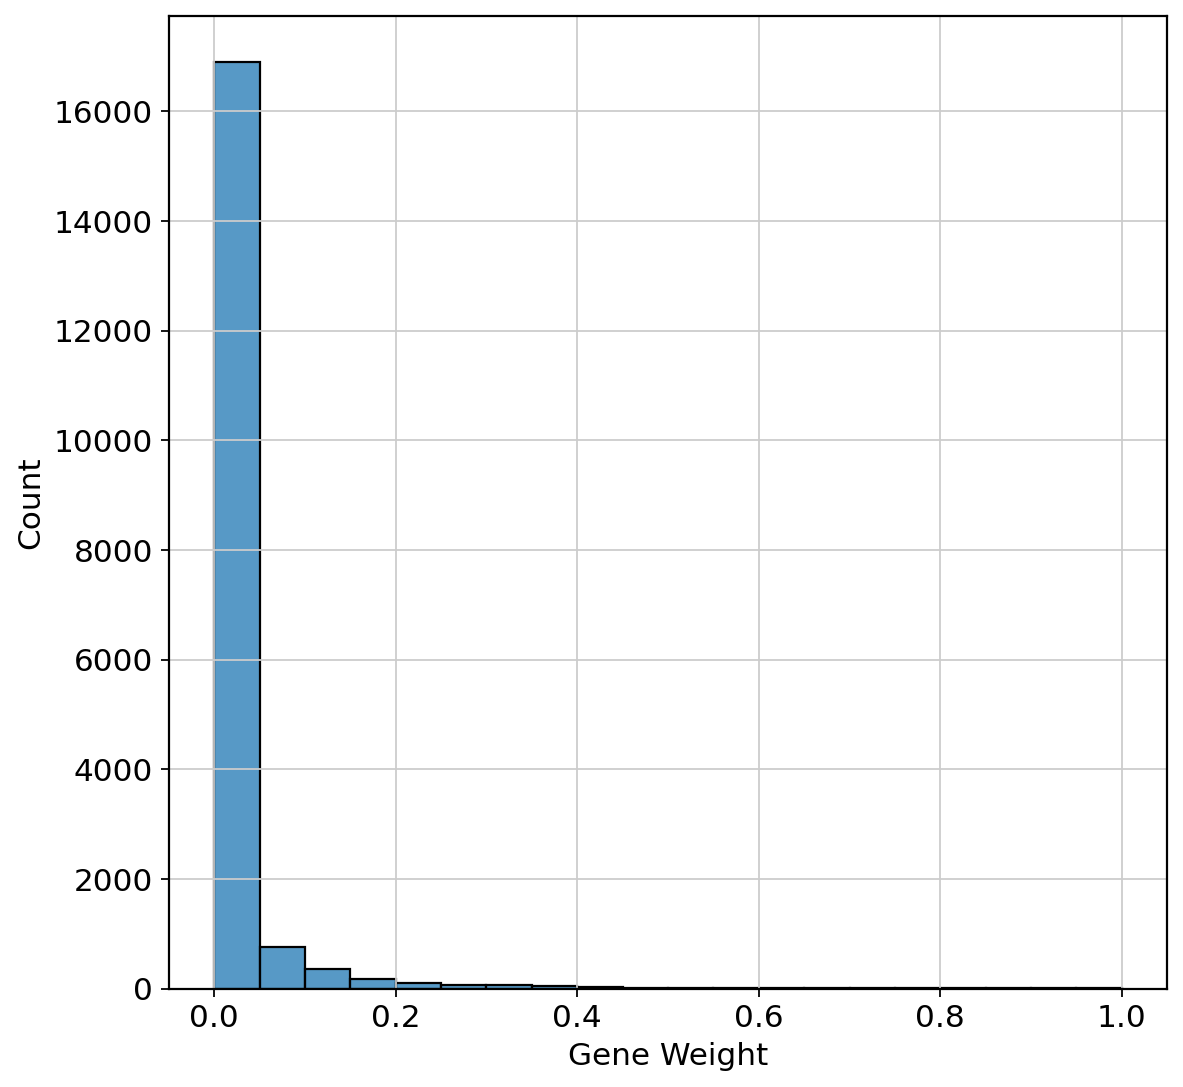

In [15]:
decon.init_dataset(
    weight_type="score", weight_agg="max",
    inverse_weight=False, log_weight=False,
    quantiles=(0, 1) #0,1
)
dv.pl.gene_weight_hist(
    decon.adata.varm["gene_weights"],
    f"Gene Weight",
    logy=False,
)

In [20]:
res = decon.deconvolute(
    model_type="lrm",
    num_epochs=1000,
    lr=0.1,
    use_outlier_genes=False,
    progress_bar=False,
    signature_quantiles=(0, 1.0), # 0,0.9
    log_loss=False
)
res

array([[0.768511  , 0.22984135, 0.00164768]])

In [21]:
df0 = adata.uns["de"]["cellType"]["0 vs. rest"].sort_values("score")
df1 = adata.uns["de"]["cellType"]["1 vs. rest"].sort_values("score")
df2 = adata.uns["de"]["cellType"]["2 vs. rest"].sort_values("score")

In [25]:
df0.index[-10:]

Index(['RP11.10A14.5', 'SLC1A6', 'WNT6', 'KRT5', 'VGLL1', 'RP11.91J3.3',
       'MAGEA12', 'AZGP1', 'MAGEA3', 'MAGEA6'],
      dtype='object', name='0_vs_rest')

In [45]:
px.scatter(
    x=adata[:, df0.index[-100:]].layers["counts"].sum(0),
    y=adata[:, df0.index[-100:]].varm["bulk"][:, 0],
    # log_x=True, log_y=True,
    trendline="ols"
)

In [27]:
scout.ply.violin(adata, "WNT6", "cellType")

In [ ]:
x = np.log1p(adata.varm["pseudo"][:, 0])
# x = x / x.sum()
y = np.log1p(adata.varm["bulk"][:, 0])
# y = y / y.sum()
px.scatter(
    x=x,
    y=y,
)

In [ ]:
# est_bulk = np.log1p(np.sum(adata.varm["mu_expression_cellType"] * [0.6, 0.3, 0.1] * 3277, axis=1))
est_bulk = np.log1p(np.sum(adata.varm["mu_expression_cellType"] * lrm.get_counts().detach().numpy(), axis=1))
true_bulk = np.log1p(adata.varm["bulk"][:, 0])

mu = adata.X.mean(0)
pf = adata.varm["pseudo_factor"][:, 0]
dist = true_bulk - est_bulk

f = px.scatter(
    x=mu,
    y=dist,
    color=adata.varm["gene_weights"],
    hover_name=adata.var_names,
)
f
# f.add_trace(
#     go.Scatter(x=[x.min(), x.max()], y=[y.min(), y.max()], mode="lines", line=dict(dash="dash"))
# )